In [1]:
## this file considers feature selection technique as label

import pandas as pd
import seaborn as sb
import math
import numpy as np
import os
import re
import jenkspy
from ast import literal_eval

import matplotlib.pyplot as plt

import pandas as pd
import os
from glob import glob
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

In [2]:
import os
print(os.getcwd())

/home/d19125691/Documents/Experiments/ontologyDCQ/FeatureSelectionRecommendation


## Generating label issues perc

In [ ]:
#Need to run only once after generating MetaFeatures
df = pd.read_csv("MetaFeatures.csv")

df['LabelIssuesPerc'] = df['LabelIssues'].apply(len) / df['nr_inst']

df.to_csv("df_mfeatures.csv",index=False)

## Reading files

In [8]:
df1 = pd.read_csv("df_mfeatures.csv")
df2 = pd.read_csv("df_ensemble_allfeatures.csv")

binDF = pd.read_csv("BinnedMetaFeatures.csv")

In [9]:
#Additional analysis for GR
df2['MaxAccuracy'] = df2.groupby('File')['Accuracy'].transform('max')

df2['IsMax'] = df2['Accuracy'] == df2['MaxAccuracy']

max_accuracy_counts = df2[df2['IsMax']].groupby('File').size()

result = max_accuracy_counts.reset_index(name='NumFSWithMaxAccuracy')

gr_max = df2[(df2['FeatureAlgo'] == 'GR') & (df2['Accuracy'] == df2['MaxAccuracy'])]

num_files_gr_is_max = gr_max['File'].nunique()

print("Number of datasets where GR has the highest accuracy:", {num_files_gr_is_max})

Number of datasets where GR has the highest accuracy: {66}


In [10]:
#Additional analysis of specific files 
directory = "./optimalalphabeta/dearr_cont"

target_params = [(0.02, 0.0), (0.0, 0.0)]

chisquare_datasets = {}
GR_datasets = {}


for file in os.listdir(directory):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)
        if (alpha, beta) in target_params:
            df = pd.read_csv(os.path.join(directory, file))
            selected_chisquare = df[df['FeatureAlgo'] == 'GR']['File'].tolist()
            selected_GR = df[df['FeatureAlgo'] == 'GR']['File'].tolist()
            chisquare_datasets[(alpha, beta)] = selected_chisquare
            GR_datasets[(alpha, beta)] = selected_GR

alpha_08_chi = set(chisquare_datasets.get((0.02, 0.0), []))
alpha_10_chi = set(chisquare_datasets.get((0.0, 0.0), []))

set(gr_max['File']) - set(alpha_10_chi) 

{'soybean-small.data', 'yeast-2_vs_8.csv'}

In [18]:
df = df2.copy()
df['MaxAccuracy'] = df.groupby('File')['Accuracy'].transform('max')

df['IsMax'] = df['Accuracy'] == df['MaxAccuracy']

max_counts = df[df['IsMax']].groupby('File').size()

unique_max_files = max_counts[max_counts == 1].index

unique_max_rows = df[(df['File'].isin(unique_max_files)) & (df['IsMax'])]

gr_unique_max_count = (unique_max_rows['FeatureAlgo'] == 'GR').sum()

print("Number of datasets where GR uniquely has the highest accuracy: ", gr_unique_max_count)

Number of datasets where GR uniquely has the highest accuracy: 5


In [3]:
df_new = df1[['File', 'Completeness', 'Conciseness', 'cor.mean', 'cov.mean',
       'eigenvalues.mean', 'g_mean.mean', 'h_mean.mean', 'iq_range.mean', 'kurtosis.mean', 
       'mad.mean', 'max.mean', 'mean.mean', 'median.mean', 'min.mean', 'nr_cor_attr',
       'nr_norm', 'nr_outliers', 'range.mean', 'sd.mean', 'skewness.mean',
       'sparsity.mean', 't_mean.mean',   'var.mean', 'ClassImbRatio',
       'ClassOverlapPerc', 'OutlierPerc', 'attr_to_inst', 'inst_to_attr', 'nr_attr',
        'nr_bin',  'nr_inst', 'nr_num', 'attr_conc.mean', 'attr_ent.mean', 'ena', 'nUnique' ,'snr.mean', 'cEntropy','LabelIssuesPerc']] #SyntaxAccuracy removed

df_bin_new = binDF[['Completeness_bins', 'Conciseness_bins',  'cor.mean_bins', 'cov.mean_bins', 
              'eigenvalues.mean_bins', 'g_mean.mean_bins', 'h_mean.mean_bins', 'iq_range.mean_bins', 'kurtosis.mean_bins',
              'mad.mean_bins', 'max.mean_bins',  'mean.mean_bins', 'median.mean_bins',  'min.mean_bins', 'nr_cor_attr_bins', 
              'nr_norm_bins', 'nr_outliers_bins', 'range.mean_bins', 'sd.mean_bins', 'skewness.mean_bins',
              'sparsity.mean_bins', 't_mean.mean_bins', 'var.mean_bins', 'LabelIssues_bins', 'ClassImbRatio_bins', 
              'OutlierPerc_bins', 'ClassOverlapPerc_bins', 'attr_to_inst_bins', 'inst_to_attr_bins', 'nr_attr_bins',
              'nr_inst_bins', 'nr_num_bins', 'nr_bin_bins', 'attr_conc.mean_bins', 'cEntropy_bins', 'ena_bins', 'snr.mean_bins', 'nUnique_bins','attr_ent.mean_bins', 'File']] #'SyntaxAccuracy_bins' removed

In [6]:
def extract_rows(df, alpha, beta, sort):
    earr = []
    fmrr = []
    fwrr = []
    no_of_feature_algo = 9
    total_comb = no_of_feature_algo * (no_of_feature_algo-1)

    df['F1 macro'] = (2*df['Precision macro']*df['Recall macro']) / (df['Precision macro'] + df['Recall macro'])
    df['F1 weight'] = (2*df['Precision weight']*df['Recall weight']) / (df['Precision weight'] + df['Recall weight'])
    x = 1
    count = 0
    for i in range(0, df.shape[0]): #dataset
      tempfmrr = []
      tempfwrr = []
      tempearr = []
      for j in range(9):
        if (i!=j+9*(x-1)):
          tempearr.append((df['Accuracy'][i] / df['Accuracy'][j+9*(x-1)]) /
          ( 1 + alpha*  math.log10(df['Time FS'][i] / df['Time FS'][j+9*(x-1)])+ beta * math.log10(df['Features'][i]/ df['Features'][j+9*(x-1)])))
          tempfmrr.append((df['F1 macro'][i] / df['F1 macro'][j+9*(x-1)]) /( 1 + 
          (alpha* math.log10(df['Time FS'][i] / df['Time FS'][j+9*(x-1)])) +
          ( beta * math.log10(df['Features'][i]/ df['Features'][j+9*(x-1)]))))
          tempfwrr.append((df['F1 weight'][i] / df['F1 weight'][j+9*(x-1)]) /( 1 + (alpha* math.log10(df['Time FS'][i] /
           df['Time FS'][j+9*(x-1)])) +( beta * math.log10(df['Features'][i]/ df['Features'][j+9*(x-1)]))))

          count=count+1

          if count==total_comb:
            x=x+1
            count=0
            break
      earr.append(sum(tempearr)/(no_of_feature_algo-1))
      fmrr.append(sum(tempfmrr)/(no_of_feature_algo-1))
      fwrr.append(sum(tempfwrr)/(no_of_feature_algo-1))
    
    df['earr'] = earr
    df['fmrr'] = fmrr
    df['fwrr'] = fwrr
    df1 = df.sort_values(['File',sort], ascending=[1,False])
    df3 = df1.groupby('File').first().reset_index()
    return df3

## Extract FS technique based on  EARR, FWRR and FMRR

In [7]:
root = './optimalalphabeta/dearr_cont/'
for i in np.arange(0, 0.11, 0.02):
    for j in np.arange(0,0.11, 0.02):
        df_optimal = extract_rows(df2, i, j, 'earr')
        merge_features = pd.merge(df_new, df_optimal[['File','FeatureAlgo']], on=['File'])
        merge_features.to_csv(root+"dearr"+str(i)+"_"+str(j)+".csv", index=False)

In [7]:
root = './optimalalphabeta/dearr_bin/'
for i in np.arange(0, 0.11, 0.02):
  for j in np.arange(0,0.11, 0.02):
    df_optimal = extract_rows(df2, i, j, 'earr')
    merge_features = pd.merge(df_bin_new, df_optimal[['File','FeatureAlgo']], on=['File'])
    merge_features.to_csv(root+"dearr"+str(i)+"_"+str(j)+".csv", index=False)

In [8]:
root = './optimalalphabeta/dfmrr_cont/'
for i in np.arange(0, 0.11, 0.02):
  for j in np.arange(0,0.11, 0.02):
    df_optimal = extract_rows(df2, i, j, 'fmrr')
    merge_features = pd.merge(df_new, df_optimal[['File','FeatureAlgo']], on=['File'])
    merge_features.to_csv(root+"dfmrr"+str(i)+"_"+str(j)+".csv", index=False)

In [8]:
root = './optimalalphabeta/dfmrr_bin/'
for i in np.arange(0, 0.11, 0.02):
  for j in np.arange(0,0.11, 0.02):
    df_optimal = extract_rows(df2, i, j, 'fmrr')
    merge_features = pd.merge(df_bin_new, df_optimal[['File','FeatureAlgo']], on=['File'])
    merge_features.to_csv(root+"dfmrr"+str(i)+"_"+str(j)+".csv", index=False)

In [9]:
root = './optimalalphabeta/dfwrr_cont/'
for i in np.arange(0, 0.11, 0.02):
  for j in np.arange(0,0.11, 0.02):
    df_optimal = extract_rows(df2, i, j, 'fwrr')
    merge_features = pd.merge(df_new, df_optimal[['File','FeatureAlgo']], on=['File'])
    merge_features.to_csv(root+"dfwrr"+str(i)+"_"+str(j)+".csv", index=False)

In [9]:
root = './optimalalphabeta/dfwrr_bin/'
for i in np.arange(0, 0.11, 0.02):
  for j in np.arange(0,0.11, 0.02):
    df_optimal = extract_rows(df2, i, j, 'fwrr')
    merge_features = pd.merge(df_bin_new, df_optimal[['File','FeatureAlgo']], on=['File'])
    merge_features.to_csv(root+"dffwrr"+str(i)+"_"+str(j)+".csv", index=False)

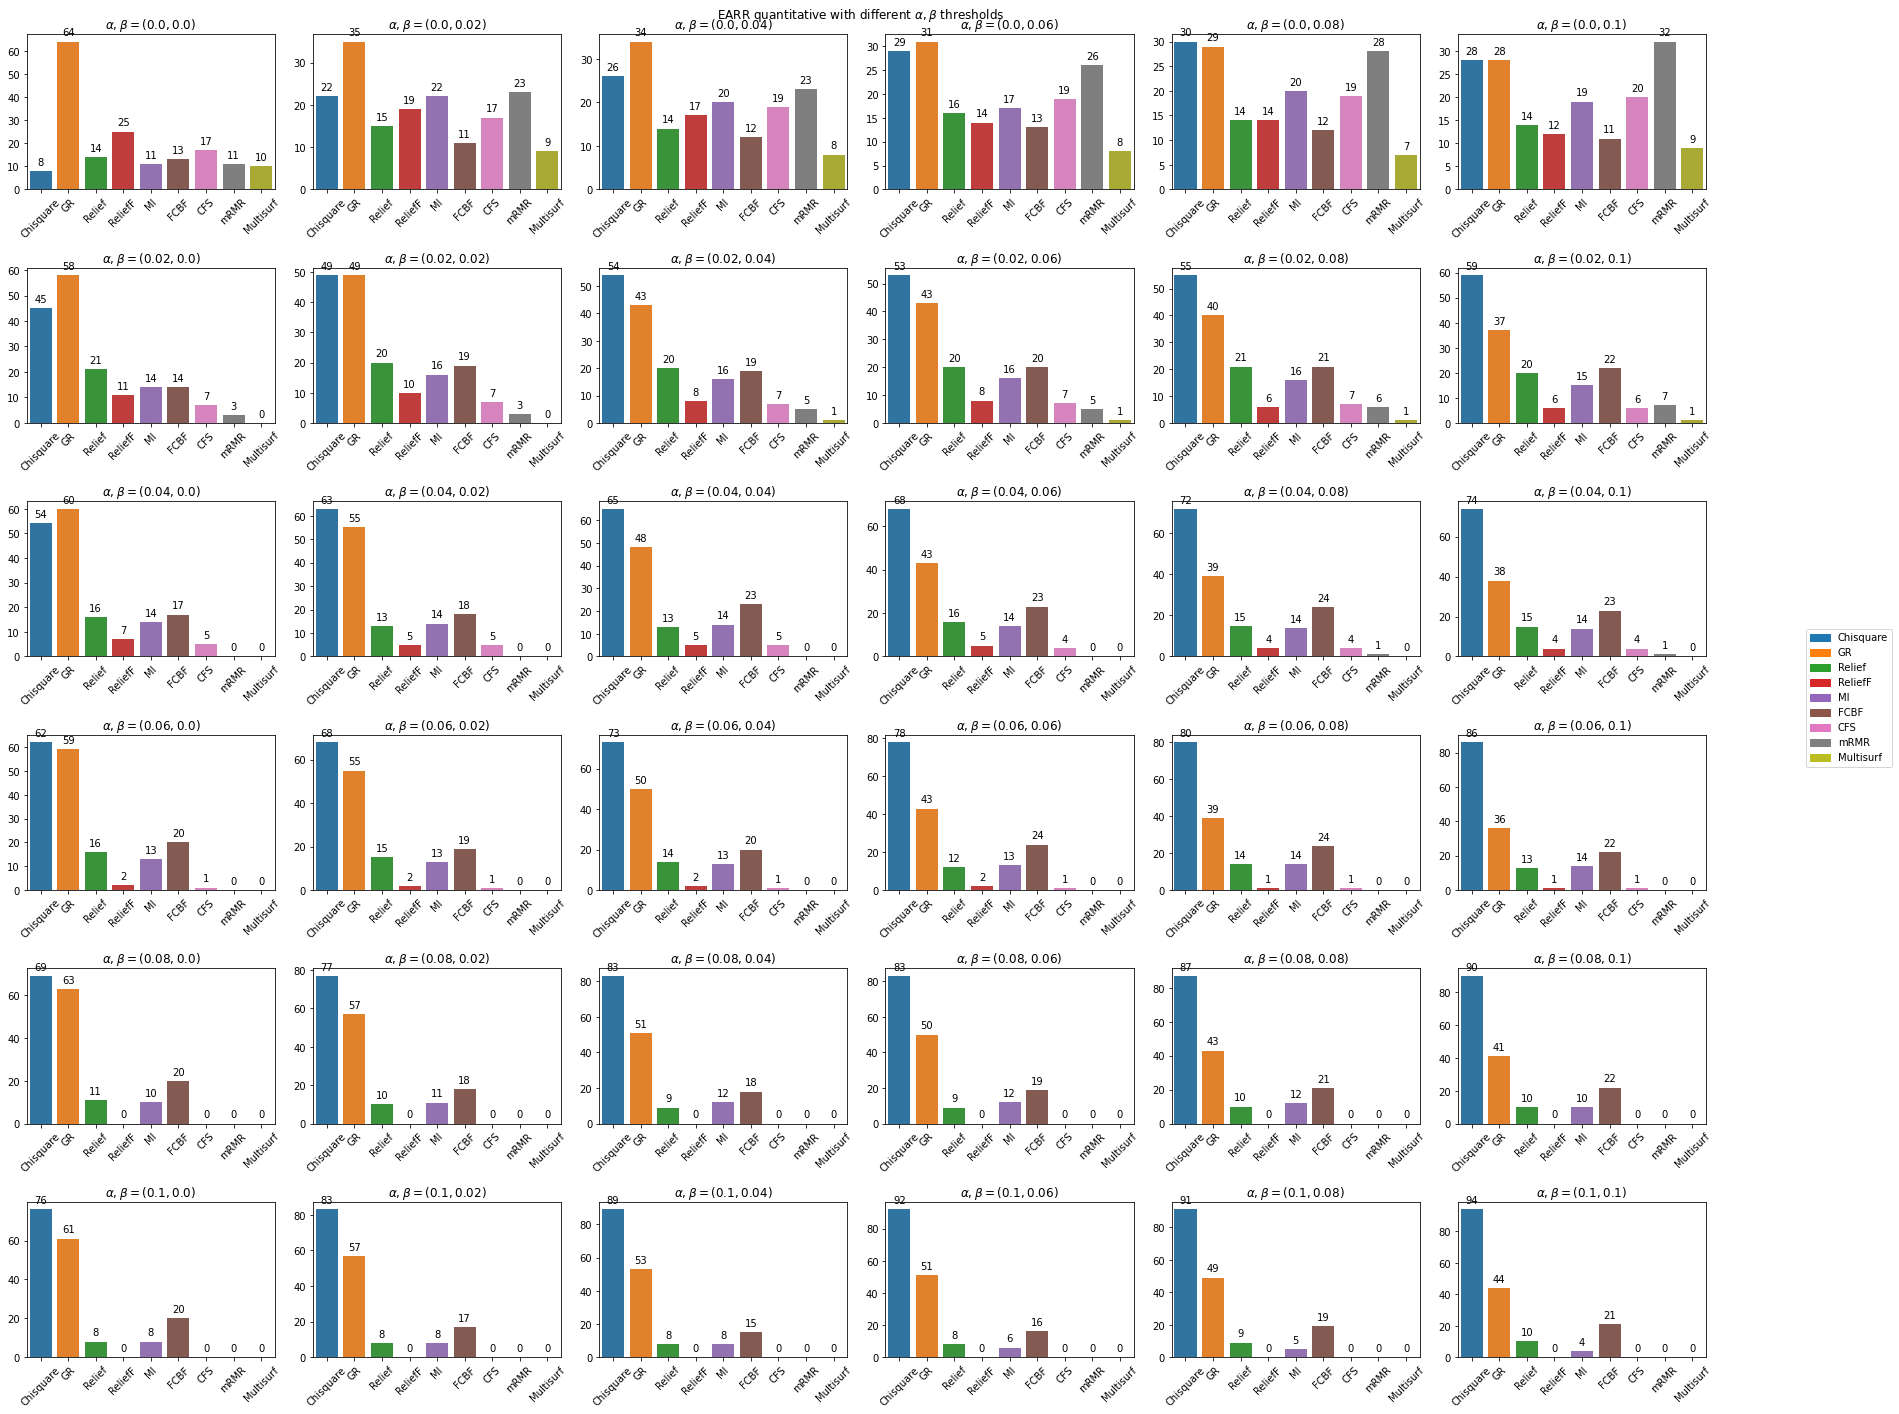

In [2]:
feature_algos = [
    'chisquare', 'GR', 'relief', 'relieff', 'MI',
    'fcbf', 'cfs', 'mrmr', 'multisurf'
]
renamed_algos = [
    'Chisquare', 'GR', 'Relief', 'ReliefF', 'MI',
    'FCBF', 'CFS', 'mRMR', 'Multisurf'
]
rename_dict = dict(zip(feature_algos, renamed_algos))

palette = sns.color_palette("tab10", len(feature_algos))
color_dict = {renamed_algos[i]: palette[i] for i in range(len(feature_algos))}

abs_path = "./optimalalphabeta/dearr_cont"

file_info = []
for file in os.listdir(abs_path):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)  # Convert to float
        file_info.append((alpha, beta, file))

file_info.sort()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24, 20), tight_layout=True)
fig.suptitle('EARR quantitative with different ' + r'$\alpha, \beta$' + ' thresholds')

results = []

for idx, (alpha, beta, file) in enumerate(file_info):
    df = pd.read_csv(os.path.join(abs_path, file))
    df['FeatureAlgo'] = df['FeatureAlgo'].map(rename_dict)  # Rename the algorithms
    value_counts = df['FeatureAlgo'].value_counts().reindex(renamed_algos, fill_value=0)
    
    results.append([alpha, beta] + value_counts.tolist())
    
    row, col = divmod(idx, 6)
    ax = axes[row][col]
    
    sns.barplot(ax=ax, x=value_counts.index, y=value_counts.values, palette=[color_dict[algo] for algo in value_counts.index])
    ax.set_title(r'$\alpha, \beta = ({}, {})$'.format(alpha, beta))
    ax.set_xticklabels(labels=value_counts.index, rotation=45)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

df_results = pd.DataFrame(results, columns=['alpha', 'beta'] + renamed_algos)

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.4)

handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(renamed_algos))]
labels = renamed_algos
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

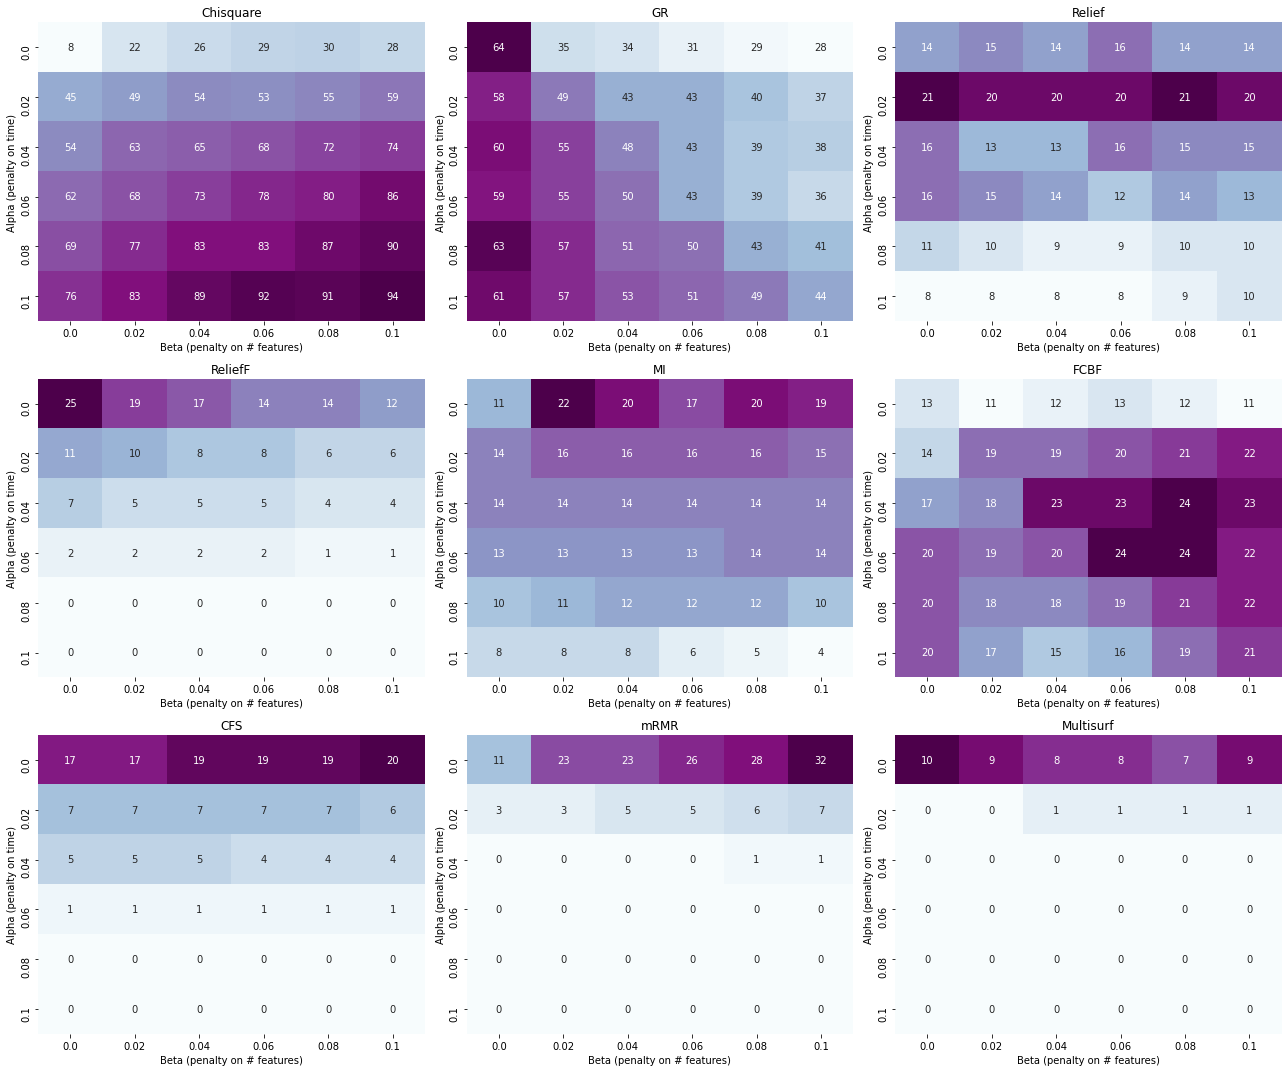

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# DataFrame (your provided values)
df = df_results

# Reshape for plotting
df_melted = df.melt(id_vars=["alpha","beta"], var_name="Technique", value_name="Frequency")

# Number of subplots
techniques = df_melted["Technique"].unique()
n = len(techniques)
cols = 3
rows = math.ceil(n / cols)

# Plot heatmaps
plt.figure(figsize=(18, 5*rows))

for i, tech in enumerate(techniques, 1):
    pivot = df_melted[df_melted["Technique"] == tech].pivot(index="alpha", columns="beta", values="Frequency")
    plt.subplot(rows, cols, i)
    sns.heatmap(pivot, annot=True, fmt="d", cmap="BuPu", cbar=False)
    plt.title(f"{tech}")
    plt.xlabel("Beta (penalty on # features)")
    plt.ylabel("Alpha (penalty on time)")

plt.tight_layout()
plt.show()


In [38]:
#Additional analysis on the graphs.

directory = "./optimalalphabeta/dearr_cont"

target_params = [(0.0, 0.0), (0.0, 0.02), (0.02, 0.0), (0.1, 0.0)]

chisquare_datasets = {}
GR_datasets = {}
abs_path = "./optimalalphabeta/dearr_cont_old"


for file in os.listdir(directory):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)
        if (alpha, beta) in target_params:
            df = pd.read_csv(os.path.join(directory, file))
            selected_chisquare = df[df['FeatureAlgo'] == 'relief']['File'].tolist()
            selected_GR = df[df['FeatureAlgo'] == 'GR']['File'].tolist()
            chisquare_datasets[(alpha, beta)] = selected_chisquare
            GR_datasets[(alpha, beta)] = selected_GR

# Compare datasets
alpha_08_chi = set(chisquare_datasets.get((0.0, 0.0), []))
alpha_10_chi = set(chisquare_datasets.get((0.0, 0.02), []))

alpha_08_gr = set(GR_datasets.get((0.08, 0.0), []))
alpha_10_gr = set(GR_datasets.get((0.10, 0.0), []))

common_chi = alpha_08_chi & alpha_10_chi
only_in_08_chi = alpha_08_chi - alpha_10_chi
only_in_10_chi = alpha_10_chi - alpha_08_chi

common_chi08_gr01 = alpha_10_chi - alpha_08_chi

print((common_chi08_gr01))
print("0.02, 0 - 0, 0 ", set(chisquare_datasets.get((0.02, 0.0), [])) - set(chisquare_datasets.get((0.0, 0.0), [])))

# Print results
#print("Datasets for alpha=0.08, beta=0.0:", alpha_08)
#print("Datasets for alpha=0.10, beta=0.0:", alpha_10)
#print("Common datasets:", len(common_chi))
#print("Only in alpha=0.08:", len(only_in_08_chi))
#print("Only in alpha=0.10:", len(only_in_10_chi))



{'4year.csv', 'ecoli3.csv', 'iris0.csv', 'Autism-Adult-Data.csv'}
0.02, 0 - 0, 0  {'ecoli-5cn01-nc.csv', 'ionosphere-5cn01-n.csv', 'ecoli3.csv', 'ecoli2.csv', 'letter-recognition.data', 'seeds_dataset.data', 'ObesityDataSet_raw_and_data_sinthetic.csv', 'congress_house-votes-84.data', 'winequality-red.csv', 'nursery.data', 'glass1.csv'}


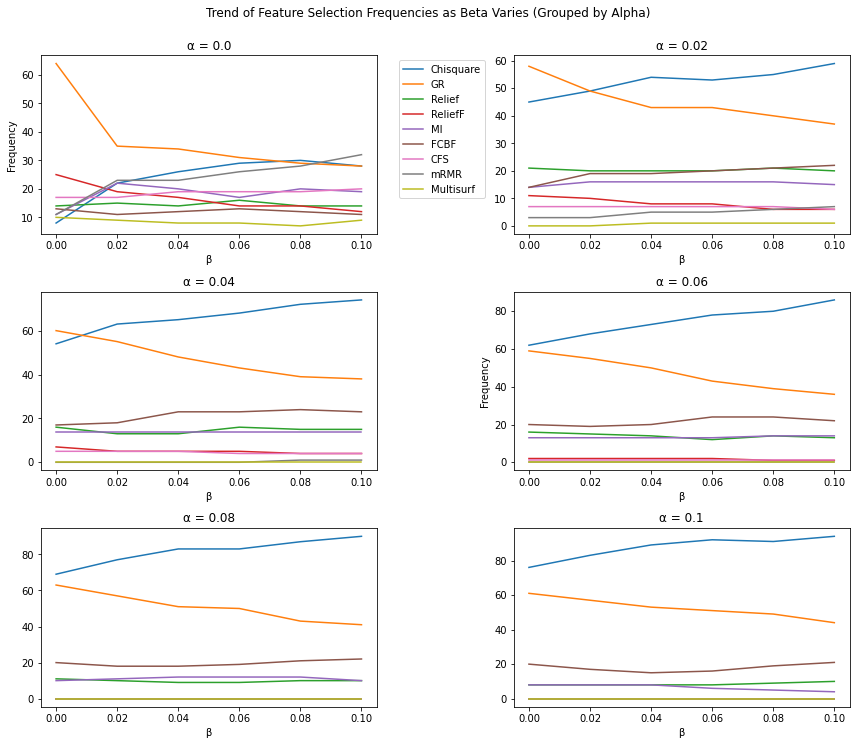

In [30]:
unique_alphas = sorted(df_results['alpha'].unique())

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

algorithms = df_results.columns[2:]

for i, alpha_val in enumerate(unique_alphas):
    ax = axs[i]
    
    df_alpha = df_results[df_results['alpha'] == alpha_val]
    
    for algo in algorithms:
        ax.plot(df_alpha['beta'], df_alpha[algo], label=algo)
    
    ax.set_title(f'α = {alpha_val}')
    ax.set_xlabel('β')
    if i % 3 == 0:
        ax.set_ylabel('Frequency')
    ax.grid(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle("Trend of Feature Selection Frequencies as Beta Varies (Grouped by Alpha)", y=1.03)
plt.show()

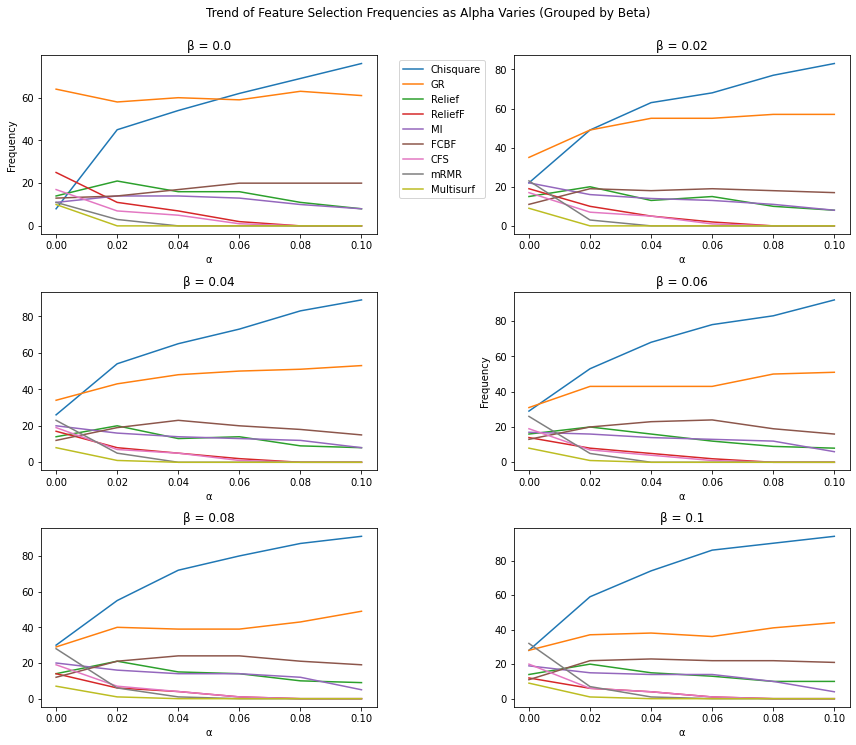

In [31]:
unique_alphas = sorted(df_results['beta'].unique())

fig, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.flatten()

algorithms = df_results.columns[2:]

for i, alpha_val in enumerate(unique_alphas):
    ax = axs[i]
    
    df_alpha = df_results[df_results['beta'] == alpha_val]
    
    for algo in algorithms:
        ax.plot(df_alpha['alpha'], df_alpha[algo], label=algo)
    
    ax.set_title(f'β = {alpha_val}')
    ax.set_xlabel('α')
    if i % 3 == 0:
        ax.set_ylabel('Frequency')
    ax.grid(False)
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.suptitle("Trend of Feature Selection Frequencies as Alpha Varies (Grouped by Beta)", y=1.03)
plt.show()

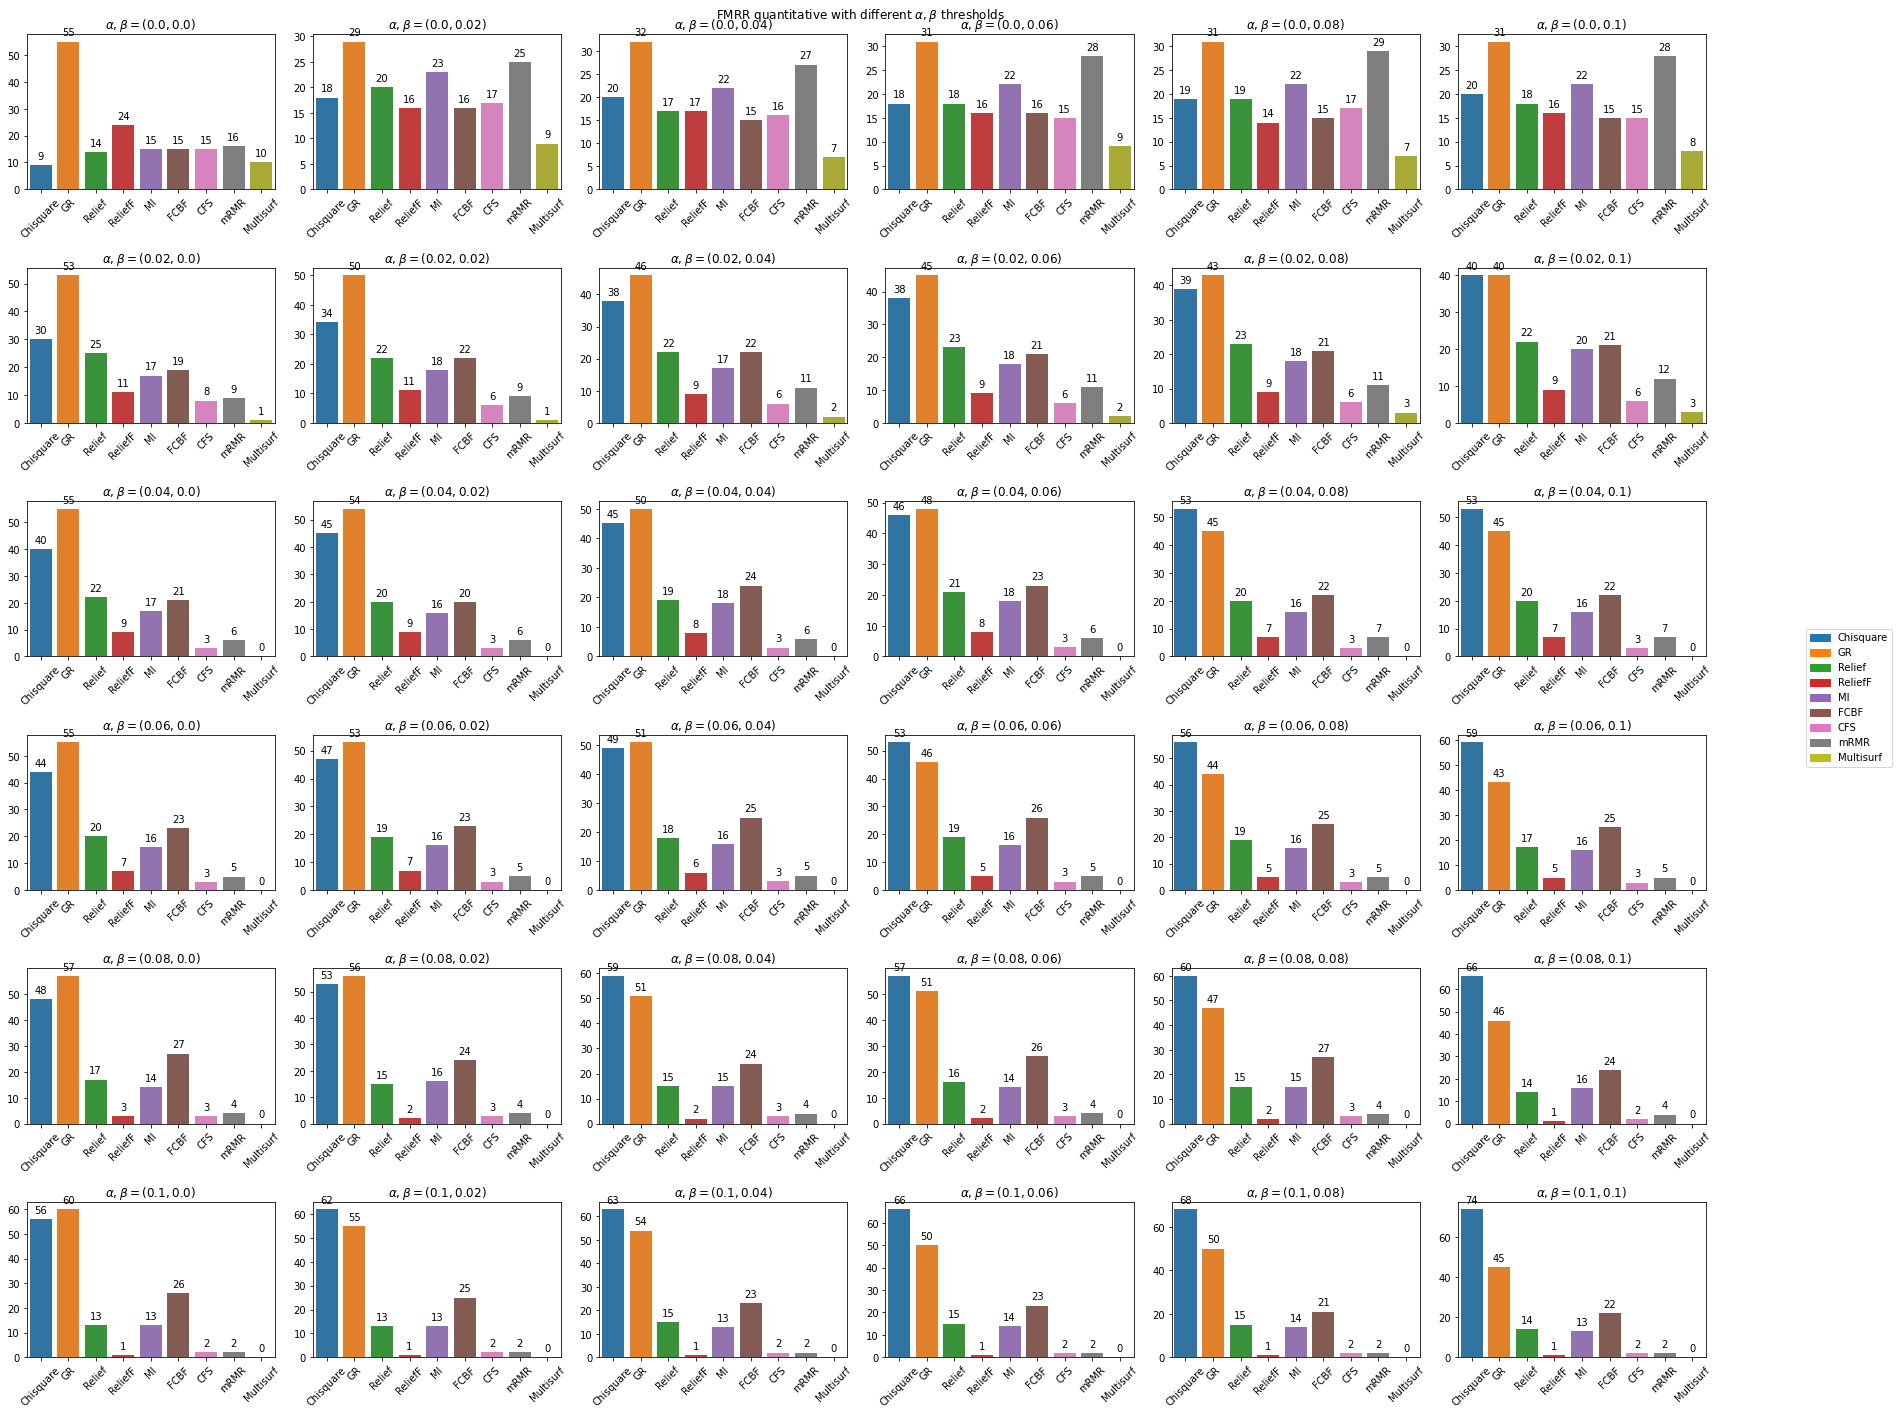

In [32]:
feature_algos = [
    'chisquare', 'GR', 'relief', 'relieff', 'MI',
    'fcbf', 'cfs', 'mrmr', 'multisurf'
]
renamed_algos = [
    'Chisquare', 'GR', 'Relief', 'ReliefF', 'MI',
    'FCBF', 'CFS', 'mRMR', 'Multisurf'
]
rename_dict = dict(zip(feature_algos, renamed_algos))

palette = sns.color_palette("tab10", len(feature_algos))
color_dict = {renamed_algos[i]: palette[i] for i in range(len(feature_algos))}

abs_path = "./optimalalphabeta/dfmrr_cont"

file_info = []
for file in os.listdir(abs_path):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)  # Convert to float
        file_info.append((alpha, beta, file))

file_info.sort()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24, 20), tight_layout=True)
fig.suptitle('FMRR quantitative with different ' + r'$\alpha, \beta$' + ' thresholds')

results = []

for idx, (alpha, beta, file) in enumerate(file_info):
    df = pd.read_csv(os.path.join(abs_path, file))
    df['FeatureAlgo'] = df['FeatureAlgo'].map(rename_dict)  # Rename the algorithms
    value_counts = df['FeatureAlgo'].value_counts().reindex(renamed_algos, fill_value=0)
    
    results.append([alpha, beta] + value_counts.tolist())
    
    row, col = divmod(idx, 6)
    ax = axes[row][col]
    
    sns.barplot(ax=ax, x=value_counts.index, y=value_counts.values, palette=[color_dict[algo] for algo in value_counts.index])
    ax.set_title(r'$\alpha, \beta = ({}, {})$'.format(alpha, beta))
    ax.set_xticklabels(labels=value_counts.index, rotation=45)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

df_results = pd.DataFrame(results, columns=['alpha', 'beta'] + renamed_algos)

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.4)

handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(renamed_algos))]
labels = renamed_algos
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

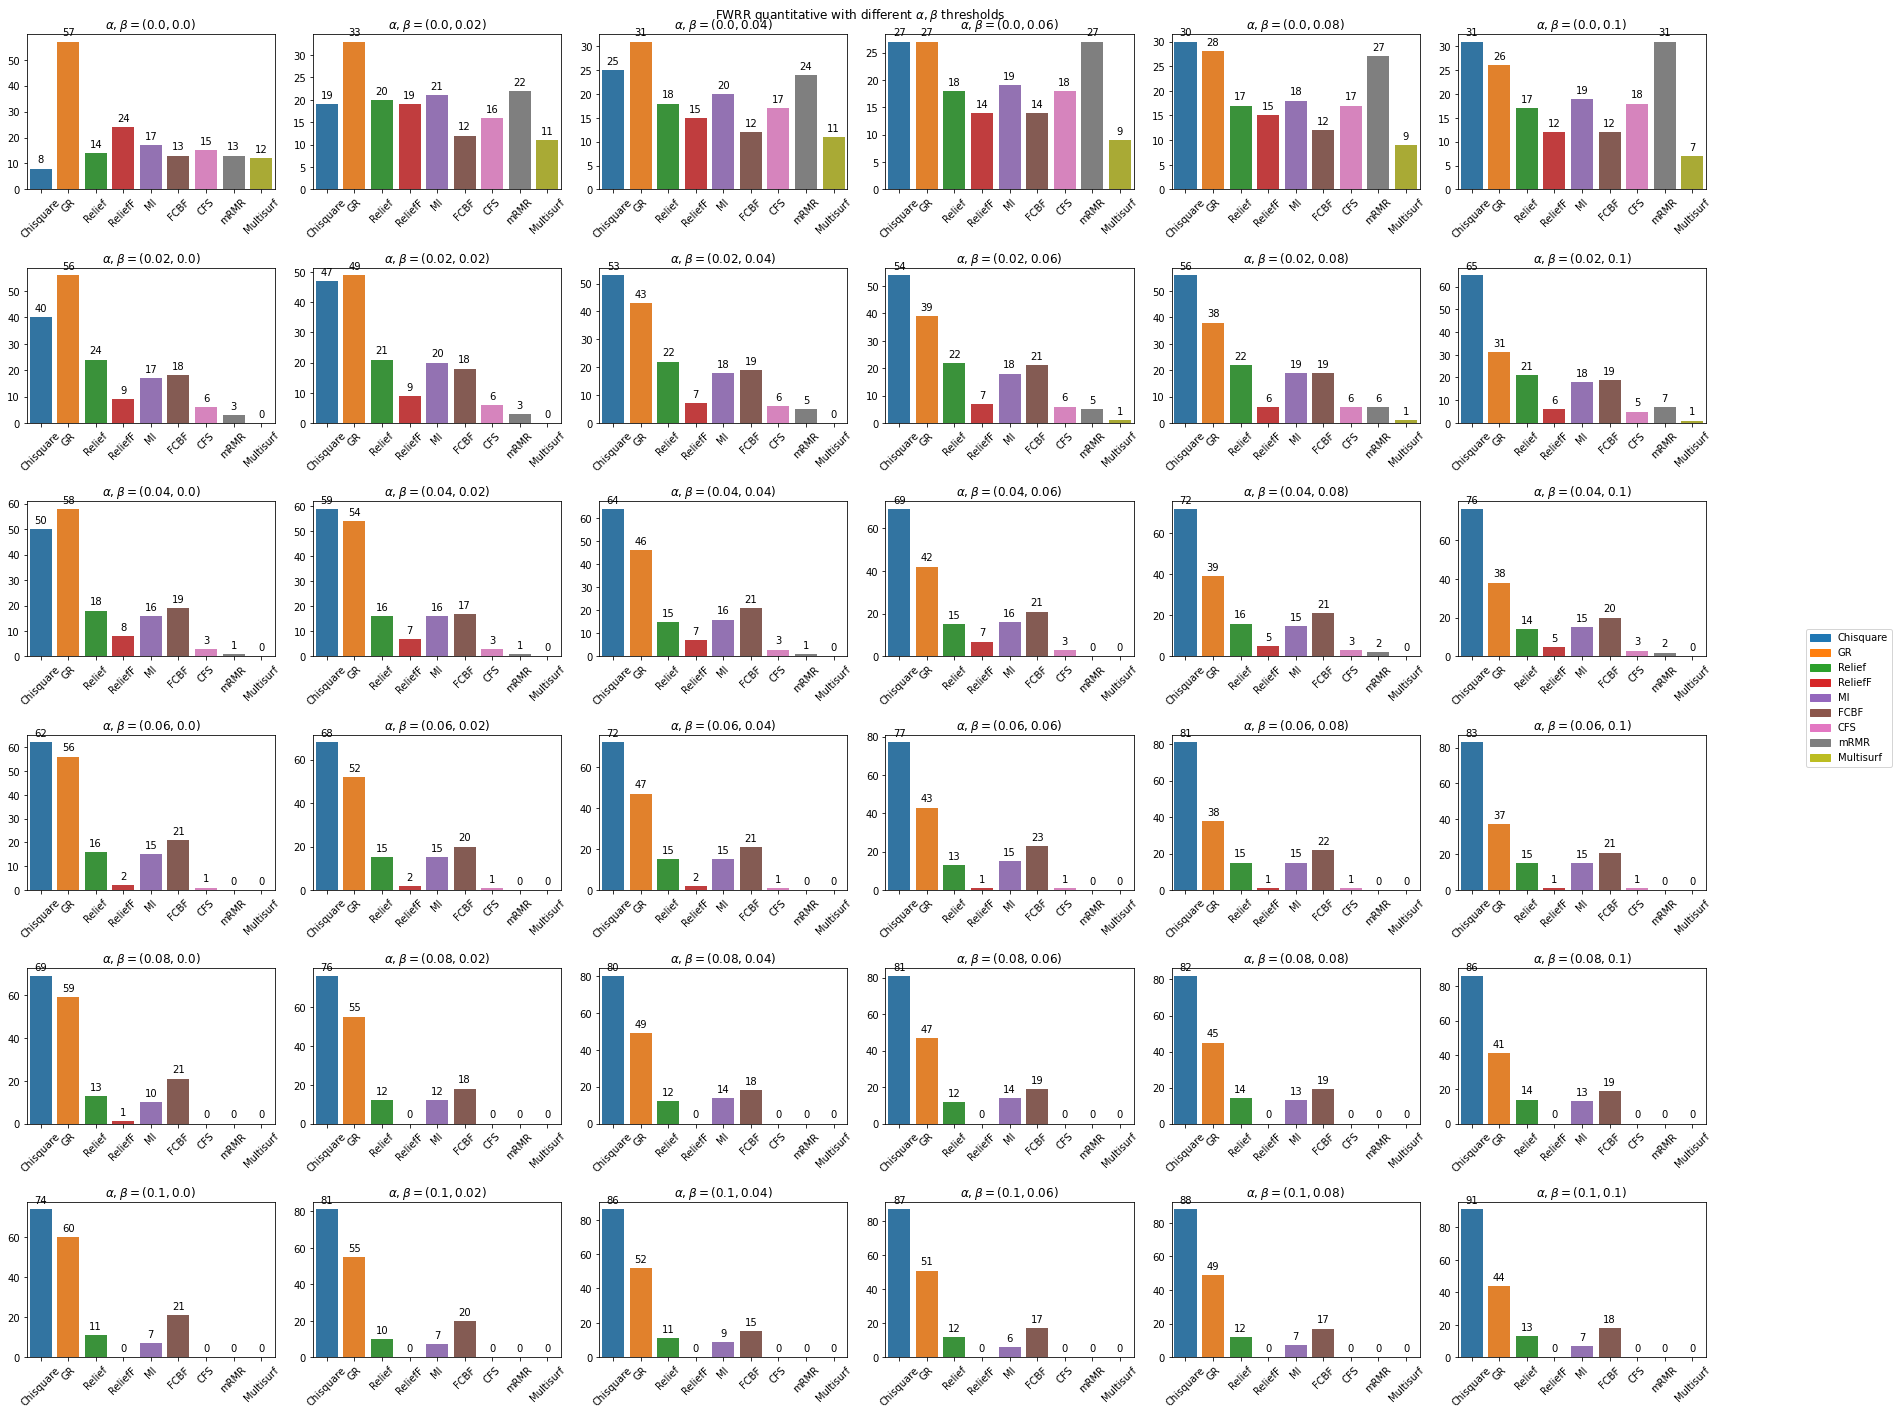

In [33]:
feature_algos = [
    'chisquare', 'GR', 'relief', 'relieff', 'MI',
    'fcbf', 'cfs', 'mrmr', 'multisurf'
]
renamed_algos = [
    'Chisquare', 'GR', 'Relief', 'ReliefF', 'MI',
    'FCBF', 'CFS', 'mRMR', 'Multisurf'
]
rename_dict = dict(zip(feature_algos, renamed_algos))

palette = sns.color_palette("tab10", len(feature_algos))
color_dict = {renamed_algos[i]: palette[i] for i in range(len(feature_algos))}

abs_path = "./optimalalphabeta/dfwrr_cont"

file_info = []
for file in os.listdir(abs_path):
    match = re.findall(r"\d+\.\d+", file)
    if match and len(match) == 2:
        alpha, beta = map(float, match)  # Convert to float
        file_info.append((alpha, beta, file))

file_info.sort()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(24, 20), tight_layout=True)
fig.suptitle('FWRR quantitative with different ' + r'$\alpha, \beta$' + ' thresholds')

results = []

for idx, (alpha, beta, file) in enumerate(file_info):
    df = pd.read_csv(os.path.join(abs_path, file))
    df['FeatureAlgo'] = df['FeatureAlgo'].map(rename_dict)  # Rename the algorithms
    value_counts = df['FeatureAlgo'].value_counts().reindex(renamed_algos, fill_value=0)
    
    results.append([alpha, beta] + value_counts.tolist())
    
    row, col = divmod(idx, 6)
    ax = axes[row][col]
    
    sns.barplot(ax=ax, x=value_counts.index, y=value_counts.values, palette=[color_dict[algo] for algo in value_counts.index])
    ax.set_title(r'$\alpha, \beta = ({}, {})$'.format(alpha, beta))
    ax.set_xticklabels(labels=value_counts.index, rotation=45)
    
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 9), textcoords='offset points')

df_results = pd.DataFrame(results, columns=['alpha', 'beta'] + renamed_algos)

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=0.3, hspace=0.4)

handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in range(len(renamed_algos))]
labels = renamed_algos
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.1, 0.5))

plt.show()

## Identification of alpha and beta threshold

In [13]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import LabelEncoder

from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, ShuffleSplit
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import preprocessing
import pandas as pd
import os
from collections import Counter
from glob import glob

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [12]:
def calcu_scores(df):
    scores = []
    labels = df['FeatureAlgo']
    features = df.drop(['FeatureAlgo', 'File'], axis=1)

    le = LabelEncoder()
    features = features.apply(le.fit_transform)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, train_size=0.8)

    param_grid_mlp = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'max_iter': [100, 200, 500]
    }

    param_grid_lr = {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga']
    }

    param_grid_svc = {
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 2000, 3000]
    }

    param_grid_dt = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 7, 9],
              'criterion' :['gini', 'entropy']
             }

    mlp_clf = GridSearchCV(MLPClassifier(random_state=1), param_grid_mlp, cv=5)
    lr_clf = GridSearchCV(LogisticRegression(random_state=0, max_iter=1000), param_grid_lr, cv=5)
    dt_clf = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
    svc_clf = GridSearchCV(LinearSVC(random_state=0), param_grid_svc, cv=5)

    mlp_clf.fit(X_train, y_train)
    lr_clf.fit(X_train, y_train)
    dt_clf.fit(X_train, y_train)
    svc_clf.fit(X_train, y_train)

    # Predictions
    mlp_predicted = mlp_clf.predict(X_test)
    lr_predicted = lr_clf.predict(X_test)
    dt_predicted = dt_clf.predict(X_test)
    svc_predicted = svc_clf.predict(X_test)

    # Append F1 scores
    for clf_name, predicted in zip(
        ['MLP', 'LR', 'RF', 'SVC'],
        [mlp_predicted, lr_predicted, dt_predicted, svc_predicted]
    ):
        scores.append(f1_score(predicted, y_test, average='macro'))
        scores.append(f1_score(predicted, y_test, average='micro'))
        scores.append(f1_score(predicted, y_test, average='weighted'))

    return scores

In [12]:
abs_path = os.getcwd()+'/optimalalphabeta/dearr_cont/'

filepaths  = [os.path.join(abs_path, name) for name in os.listdir(abs_path)]
all_files = []

for path in filepaths:
    temp = []
    df = pd.read_csv(path)
    temp.append(path)
    temp.extend(calcu_scores(df))
    all_files.append(temp)

pd.DataFrame(all_files).to_csv("earr_cont_analysis.csv", index=False, header=['File', 'MLP_macro','MLP_micro','MLP_weighted','LR_macro','LR_micro','LR_weighted','DT_macro','DT_micro','DT_weighted', 'SVC_macro','SVC_micro','SVC_weighted'])

/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selecti

In [13]:
abs_path = os.getcwd()+'/optimalalphabeta/dfmrr_cont/'

filepaths  = [os.path.join(abs_path, name) for name in os.listdir(abs_path)]
all_files = []

for path in filepaths:
    temp = []
    df = pd.read_csv(path)
    temp.append(path)
    temp.extend((calcu_scores(df)))
    all_files.append(temp)

pd.DataFrame(all_files).to_csv("fmrr_cont_analysis.csv", index=False, header=['File', 'MLP_macro','MLP_micro','MLP_weighted','LR_macro','LR_micro','LR_weighted','DT_macro','DT_micro','DT_weighted', 'SVC_macro','SVC_micro','SVC_weighted'])

/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selecti

In [8]:
abs_path = os.getcwd()+'/optimalalphabeta/dfwrr_cont/'

filepaths  = [os.path.join(abs_path, name) for name in os.listdir(abs_path)]
all_files = []

for path in filepaths:
    temp = []
    df = pd.read_csv(path)
    temp.append(path)
    temp.extend((calcu_scores(df)))
    all_files.append(temp)

pd.DataFrame(all_files).to_csv("fwrr_cont_analysis.csv",  index=False, header=['File', 'MLP_macro','MLP_micro','MLP_weighted','LR_macro','LR_micro','LR_weighted','DT_macro','DT_micro','DT_weighted', 'SVC_macro','SVC_micro','SVC_weighted'])

/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selecti

In [ ]:
abs_path = os.getcwd()+'/optimalalphabeta/dearr_bin/'

filepaths  = [os.path.join(abs_path, name) for name in os.listdir(abs_path)]
all_files = []

for path in filepaths:
    temp = []
    df = pd.read_csv(path)
    temp.append(path)
    temp.extend((calcu_scores(df)))
    all_files.append(temp)

pd.DataFrame(all_files).to_csv("earr_bin_analysis.csv",  index=False, header=['File', 'MLP_macro','MLP_micro','MLP_weighted','LR_macro','LR_micro','LR_weighted','DT_macro','DT_micro','DT_weighted', 'SVC_macro','SVC_micro','SVC_weighted'])

In [ ]:
abs_path = os.getcwd()+'/optimalalphabeta/dfmrr_bin/'

filepaths  = [os.path.join(abs_path, name) for name in os.listdir(abs_path)]
all_files = []

for path in filepaths:
    temp = []
    df = pd.read_csv(path)
    temp.append(path)
    temp.extend((calcu_scores(df)))
    all_files.append(temp)

pd.DataFrame(all_files).to_csv("fmrr_bin_analysis.csv", index=False, header=['File', 'MLP_macro','MLP_micro','MLP_weighted','LR_macro','LR_micro','LR_weighted','DT_macro','DT_micro','DT_weighted', 'SVC_macro','SVC_micro','SVC_weighted'])

In [ ]:
abs_path = os.getcwd()+'/optimalalphabeta/dfwrr_bin/'

filepaths  = [os.path.join(abs_path, name) for name in os.listdir(abs_path)]
all_files = []

for path in filepaths:
    temp = []
    df = pd.read_csv(path)
    temp.append(path)
    temp.extend((calcu_scores(df)))
    all_files.append(temp)

pd.DataFrame(all_files).to_csv("fwrr_bin_analysis.csv",  index=False, header=['File', 'MLP_macro','MLP_micro','MLP_weighted','LR_macro','LR_micro','LR_weighted','DT_macro','DT_micro','DT_weighted', 'SVC_macro','SVC_micro','SVC_weighted'])

Additional methods, such as majority voting, have been explored to assess whether they offer any improvement in accuracy.

In [ ]:

path = os.getcwd()+'/optimalalphabeta/dearr_cont/' 
csv_files = glob(os.path.join(path, 'dearr*.csv'))

labels_dict = {}

for file in csv_files:
    df = pd.read_csv(file)
    
    for idx, row in df.iterrows():
        dataset_id = row['File'] 
        best_fs = row['FeatureAlgo']   
        
        if dataset_id not in labels_dict:
            labels_dict[dataset_id] = []
        labels_dict[dataset_id].append(best_fs)

majority_labels = {
    dataset: Counter(fs_list).most_common(1)[0][0]
    for dataset, fs_list in labels_dict.items()
}

majority_df = pd.DataFrame(list(majority_labels.items()), columns=['File', 'FeatureAlgo'])
majority_df.to_csv('majority_voted_labels.csv', index=False)

In [40]:
df1 = pd.read_csv('majority_voted_labels.csv')

merged_df = pd.merge(df1, df_new, on='File', how='inner')

res = calcu_scores(merged_df)
print(res)

/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[0.34794853294853295, 0.45714285714285713, 0.48298330241187387, 0.316374269005848, 0.5428571428571428, 0.6090225563909775, 0.2257936507936508, 0.42857142857142855, 0.47734693877551015, 0.2899562123700055, 0.4000000000000001, 0.4232465399953086]


However, the results were not particularly promising. Therefore, majority voting was not pursued further.


The analysis was continued with more exploration. 


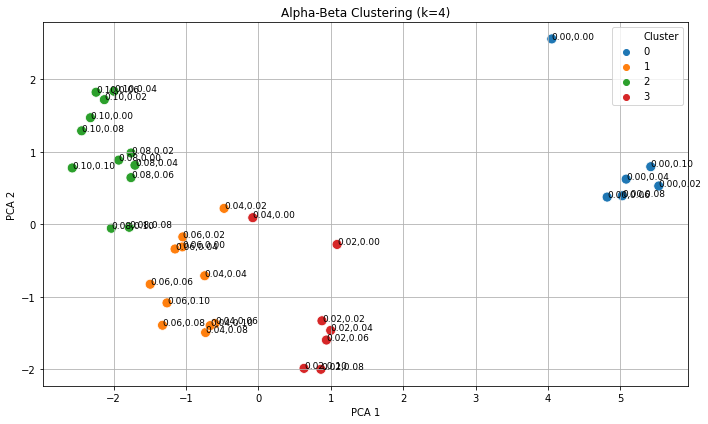

In [15]:
path = os.getcwd()+'/optimalalphabeta/dearr_cont/'  
label_column = 'FeatureAlgo'   
output_dim = 2         
n_clusters = 4    

csv_files = sorted(glob(os.path.join(path, 'dearr*.csv')))

all_fs_algos = set()
fs_distributions = []
ab_values = []

for file in csv_files:
    df = pd.read_csv(file)
    fs_counts = Counter(df[label_column])
    all_fs_algos.update(fs_counts.keys())
    fs_distributions.append(fs_counts)
    
    ab = file.split('/')[-1].replace('dearr', '').replace('.csv', '')
    alpha, beta = map(float, ab.split('_'))
    ab_values.append((alpha, beta))

fs_algos = sorted(list(all_fs_algos))

matrix = []
for dist in fs_distributions:
    vector = [dist.get(fs, 0) for fs in fs_algos]
    matrix.append(vector)

df_matrix = pd.DataFrame(matrix, columns=fs_algos)
df_matrix.index = [f'{a}_{b}' for a, b in ab_values]

scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(df_matrix)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(scaled_matrix)

pca = PCA(n_components=output_dim)
reduced = pca.fit_transform(scaled_matrix)

plot_df = pd.DataFrame({
    'Alpha': [a for a, b in ab_values],
    'Beta': [b for a, b in ab_values],
    'Cluster': labels,
    'PC1': reduced[:, 0],
    'PC2': reduced[:, 1],
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=100)
for i, (a, b) in enumerate(zip(plot_df['Alpha'], plot_df['Beta'])):
    plt.text(plot_df.loc[i, 'PC1'], plot_df.loc[i, 'PC2'], f'{a:.2f},{b:.2f}', fontsize=9)

plt.title(f'Alpha-Beta Clustering (k={n_clusters})')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
cluster_df = pd.DataFrame({
    'File': df_matrix.index,
    'Cluster': labels
})

cluster_counts = cluster_df['Cluster'].value_counts().sort_index()

print("Number of alpha-beta files in each cluster:")
print(cluster_counts)

print("\nDetailed files per cluster:")
for cluster_id, group in cluster_df.groupby('Cluster'):
    print(f"\nCluster {cluster_id} ({len(group)} files):")
    print(group['File'].tolist())


Number of alpha-beta files in each cluster:
0     6
1    11
2    12
3     7
Name: Cluster, dtype: int64

Detailed files per cluster:

Cluster 0 (6 files):
['0.0_0.0', '0.0_0.02', '0.0_0.04', '0.0_0.06', '0.0_0.08', '0.0_0.1']

Cluster 1 (11 files):
['0.04_0.02', '0.04_0.04', '0.04_0.06', '0.04_0.08', '0.04_0.1', '0.06_0.0', '0.06_0.02', '0.06_0.04', '0.06_0.06', '0.06_0.08', '0.06_0.1']

Cluster 2 (12 files):
['0.08_0.0', '0.08_0.02', '0.08_0.04', '0.08_0.06', '0.08_0.08', '0.08_0.1', '0.1_0.0', '0.1_0.02', '0.1_0.04', '0.1_0.06', '0.1_0.08', '0.1_0.1']

Cluster 3 (7 files):
['0.02_0.0', '0.02_0.02', '0.02_0.04', '0.02_0.06', '0.02_0.08', '0.02_0.1', '0.04_0.0']


In [18]:

path = os.getcwd()+'/optimalalphabeta/clusteredearr/' 
csv_files = glob(os.path.join(path, 'dearr*.csv'))


labels_dict = {}

for file in csv_files:
    df = pd.read_csv(file)
    
    for idx, row in df.iterrows():
        dataset_id = row['File']  
        best_fs = row['FeatureAlgo']   
        
        if dataset_id not in labels_dict:
            labels_dict[dataset_id] = []
        labels_dict[dataset_id].append(best_fs)

majority_labels = {
    dataset: Counter(fs_list).most_common(1)[0][0]
    for dataset, fs_list in labels_dict.items()
}

majority_df = pd.DataFrame(list(majority_labels.items()), columns=['File', 'FeatureAlgo'])
majority_df.to_csv('majority_voted_labels_clusteredearr.csv', index=False)

In [41]:
df1 = pd.read_csv('majority_voted_labels_clusteredearr.csv')

merged_df = pd.merge(df1, df_new, on='File', how='inner')  # use 'left', 'right', or 'outer' as needed

res1 = calcu_scores(merged_df)
print(res1)

[0.3631578947368421, 0.6, 0.6315789473684211, 0.2755852842809364, 0.6285714285714286, 0.7141901576684185, 0.2456470588235294, 0.5142857142857142, 0.5585210084033613, 0.268018018018018, 0.6, 0.6707207207207206]


The results improved slightly after applying clustering. However, there is a promising improvement when the average of weighted F1 score of all the models is considered. The files are grouped under four cluster heads, revealing correlations among their alpha values. 

The analysis continued with a deeper exploration of correlation features, using the labels generated from the clustering process.

In [48]:
def correlation_filter(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)


print(f"Shape before filtering: {df_new.shape}")
X_filtered = correlation_filter(pd.DataFrame(df_new, columns=df_new.columns.drop('File')))
print(f"Shape after filtering: {X_filtered.shape}")
X_filtered = X_filtered.reset_index(drop=True)
file_column = df2['File'].reset_index(drop=True)

df_filtered_with_file = pd.concat([file_column, X_filtered], axis=1)

df1 = pd.read_csv('majority_voted_labels_clusteredearr.csv')

df2 = df_filtered_with_file.copy()
merged_df = pd.merge(df1, df2, on='File', how='inner') 
res2 = calcu_scores(merged_df)
print(res2)

Shape before filtering: (173, 40)
Shape after filtering: (173, 24)
[0.22094691535150646, 0.4857142857142857, 0.5336339413814306, 0.2590909090909091, 0.6, 0.6857142857142857, 0.25833333333333336, 0.5142857142857142, 0.5333333333333333, 0.4954545454545454, 0.6, 0.6175324675324675]


In [51]:
print("Majority voting", sum(res)/len(res))
print("Clustered:",sum(res1)/len(res1))
print("Clustered with correlation",sum(res2)/len(res2))
print("Average accuracy of weighted classifications, before correlation",(res1[2]+res1[5]+res1[8]+res1[11])/4)
print("Average accuracy of weighted classifications, after correlation",(res2[2]+res2[5]+res2[8]+res2[11])/4)


Majority voting 0.41677028593859466
Clustered: 0.5058563527397825
Clustered with correlation 0.4836699775993176
Average accuracy of weighted classifications, before correlation 0.6437527085402304
Average accuracy of weighted classifications, after correlation 0.5925535069903793


However, dropping highly correlated features did not result in any improvement. Therefore, the analysis in this direction was not pursued further.

Instead of using the feature selection technique as the label, its evaluation types were considered as the label for broader classification.


In [53]:
abs_path = os.getcwd()+'/optimalalphabeta/dearr_cont/'

filepaths  = [os.path.join(abs_path, name) for name in os.listdir(abs_path)]
all_files = []

for path in filepaths:
    temp = []
    df = pd.read_csv(path)
    merged_df = pd.merge(df[['File','FeatureAlgo']], df_filtered_with_file, on='File', how='inner') 
    temp.append(path)
    temp.extend(calcu_scores(merged_df))
    all_files.append(temp)

/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/home/d19125691/.local/lib/python3.6/site-packages/sklearn/model_selecti

Generating broader classification as the specific class technique is not yeilding good results

In [14]:
def calcu_scores_featuresetting(df):
    scores = []
    labels = df['FS_Setting']
    features = df.drop(['FeatureAlgo', 'File', 'FS_Type', 'FS_Setting'], axis=1)

    le = LabelEncoder()
    features = features.apply(le.fit_transform)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, train_size=0.8)

    param_grid_mlp = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'max_iter': [100, 200, 500]
    }

    param_grid_lr = {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga']
    }

    param_grid_svc = {
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 2000, 3000]
    }

    param_grid_dt = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 7, 9],
              'criterion' :['gini', 'entropy']
             }

    mlp_clf = GridSearchCV(MLPClassifier(random_state=1), param_grid_mlp, cv=5)
    lr_clf = GridSearchCV(LogisticRegression(random_state=0, max_iter=1000), param_grid_lr, cv=5)
    dt_clf = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
    svc_clf = GridSearchCV(LinearSVC(random_state=0), param_grid_svc, cv=5)

    mlp_clf.fit(X_train, y_train)
    lr_clf.fit(X_train, y_train)
    dt_clf.fit(X_train, y_train)
    svc_clf.fit(X_train, y_train)

    # Predictions
    mlp_predicted = mlp_clf.predict(X_test)
    lr_predicted = lr_clf.predict(X_test)
    dt_predicted = dt_clf.predict(X_test)
    svc_predicted = svc_clf.predict(X_test)

    # Append F1 scores
    for clf_name, predicted in zip(
        ['MLP', 'LR', 'RF', 'SVC'],
        [mlp_predicted, lr_predicted, dt_predicted, svc_predicted]
    ):
        scores.append(f1_score(predicted, y_test, average='macro'))
        scores.append(f1_score(predicted, y_test, average='micro'))
        scores.append(f1_score(predicted, y_test, average='weighted'))

    return scores

In [15]:
def calcu_scores_featuretype(df):
    scores = []
    labels = df['FS_Type']
    features = df.drop(['FeatureAlgo', 'File', 'FS_Type', 'FS_Setting'], axis=1)

    le = LabelEncoder()
    features = features.apply(le.fit_transform)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=42, train_size=0.8)

    param_grid_mlp = {
        'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
        'solver': ['sgd', 'adam'],
        'alpha': [0.0001, 0.05],
        'max_iter': [100, 200, 500]
    }

    param_grid_lr = {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga']
    }

    param_grid_svc = {
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000, 2000, 3000]
    }

    param_grid_dt = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 7, 9],
              'criterion' :['gini', 'entropy']
             }

    mlp_clf = GridSearchCV(MLPClassifier(random_state=1), param_grid_mlp, cv=5)
    lr_clf = GridSearchCV(LogisticRegression(random_state=0, max_iter=1000), param_grid_lr, cv=5)
    dt_clf = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
    svc_clf = GridSearchCV(LinearSVC(random_state=0), param_grid_svc, cv=5)

    mlp_clf.fit(X_train, y_train)
    lr_clf.fit(X_train, y_train)
    dt_clf.fit(X_train, y_train)
    svc_clf.fit(X_train, y_train)

    mlp_predicted = mlp_clf.predict(X_test)
    lr_predicted = lr_clf.predict(X_test)
    dt_predicted = dt_clf.predict(X_test)
    svc_predicted = svc_clf.predict(X_test)

    for clf_name, predicted in zip(
        ['MLP', 'LR', 'RF', 'SVC'],
        [mlp_predicted, lr_predicted, dt_predicted, svc_predicted]
    ):
        scores.append(f1_score(predicted, y_test, average='macro'))
        scores.append(f1_score(predicted, y_test, average='micro'))
        scores.append(f1_score(predicted, y_test, average='weighted'))

    return scores

In [16]:
fs_mapping = {
    'MI': ('Uni', 'Information'),
    'GR': ('Uni', 'Information'),
    'fcbf': ('Multi', 'Information'),
    'chisquare': ('Uni', 'Dependency'),
    'mRMR': ('Multi', 'Dependency'),
    'cfs': ('Multi', 'Dependency'),
    'relief': ('Uni', 'Distance'),
    'relieff': ('Uni', 'Distance'),
    'multisurf': ('Multi', 'Distance')
}

def get_setting(algo):
    return fs_mapping.get(algo, ('Unknown', 'Unknown')) 


df = pd.read_csv("./optimalalphabeta/dearr_cont/dearr0.1_0.06.csv")

df[['FS_Setting', 'FS_Type']] = df['FeatureAlgo'].apply(lambda x: pd.Series(get_setting(x)))

res_fs_setting = calcu_scores_featuresetting(df)
res_fs_type = calcu_scores_featuretype(df)

In [19]:
print(res_fs_setting)
print(res_fs_type)
print("FS Setting", sum(res_fs_setting)/len(res_fs_setting))
print("FS Type:",sum(res_fs_type)/len(res_fs_type))
print("Average accuracy of weighted classifications, FS Setting",(res_fs_setting[2]+res_fs_setting[5]+res_fs_setting[8]+res_fs_setting[11])/4)
print("Average accuracy of weighted classifications, FS Type",(res_fs_type[2]+res_fs_type[5]+res_fs_type[8]+res_fs_type[11])/4)

[0.4776119402985075, 0.9142857142857143, 0.955223880597015, 0.4776119402985075, 0.9142857142857143, 0.955223880597015, 0.4776119402985075, 0.9142857142857143, 0.955223880597015, 0.4776119402985075, 0.9142857142857143, 0.955223880597015]
[0.4192248062015504, 0.6285714285714286, 0.6583388704318937, 0.5285714285714285, 0.7714285714285715, 0.7946938775510203, 0.4097646033129904, 0.6, 0.6233902104869846, 0.4058479532163743, 0.6, 0.6324812030075188]
FS Setting 0.7823738450604122
FS Type: 0.5893594127316467
Average accuracy of weighted classifications, FS Setting 0.955223880597015
Average accuracy of weighted classifications, FS Type 0.6772260403693543


The results of weighted classification on the knowledge base 0.1_0.06 is promosing. Hence, the same technique is applied on majority voting of clustered file labels. 

In [20]:
fs_mapping = {
    'MI': ('Uni', 'Information'),
    'GR': ('Uni', 'Information'),
    'fcbf': ('Multi', 'Information'),
    'chisquare': ('Uni', 'Dependency'),
    'mRMR': ('Multi', 'Dependency'),
    'cfs': ('Multi', 'Dependency'),
    'relief': ('Uni', 'Distance'),
    'relieff': ('Uni', 'Distance'),
    'multisurf': ('Multi', 'Distance')
}

def get_setting(algo):
    return fs_mapping.get(algo, ('Unknown', 'Unknown')) 

df1 = pd.read_csv('majority_voted_labels_clusteredearr.csv')

merged_df = pd.merge(df1, df_new, on='File', how='inner')  # use 'left', 'right', or 'outer' as needed

#res1 = calcu_scores(merged_df)

merged_df[['FS_Setting', 'FS_Type']] = merged_df['FeatureAlgo'].apply(lambda x: pd.Series(get_setting(x)))

res_fs_setting1 = calcu_scores_featuresetting(merged_df)
res_fs_type1 = calcu_scores_featuretype(merged_df)

In [21]:
print(res_fs_setting1)
print(res_fs_type1)
print("FS Setting", sum(res_fs_setting1)/len(res_fs_setting1))
print("FS Type:",sum(res_fs_type1)/len(res_fs_type1))
print("Average accuracy of weighted classifications, FS Setting",(res_fs_setting1[2]+res_fs_setting1[5]+res_fs_setting1[8]+res_fs_setting1[11])/4)
print("Average accuracy of weighted classifications, FS Type",(res_fs_type1[2]+res_fs_type1[5]+res_fs_type1[8]+res_fs_type1[11])/4)

[0.46969696969696967, 0.8857142857142857, 0.9393939393939393, 0.4615384615384615, 0.8571428571428571, 0.8967032967032966, 0.5766129032258065, 0.8285714285714286, 0.8285714285714286, 0.453125, 0.8285714285714286, 0.8544642857142857]
[0.41203703703703703, 0.6, 0.6170634920634921, 0.45138888888888884, 0.6571428571428571, 0.6755952380952379, 0.3912037037037037, 0.5714285714285714, 0.588888888888889, 0.4312699796570764, 0.6285714285714286, 0.6472537053182214]
FS Setting 0.740008857070349
FS Type: 0.5559869825662836
Average accuracy of weighted classifications, FS Setting 0.8797832375957376
Average accuracy of weighted classifications, FS Type 0.6322003310914601


The results of FS_Type and FS_Setting of clustered majority voting are not as good as knowledge base i.e. 0.1_0.06. Further analysis is conducted on robust knowledge base 0.1_0.06 and majority_voted_clustering.